In [14]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import spacy
from spacy.lang.en import stop_words
import mlflow

# nltk.download('all')

In [15]:
mlflow.set_tracking_uri("http://127.0.0.1:8080/")
mlflow.set_experiment("/financelstm")

2024/11/02 23:02:37 INFO mlflow.tracking.fluent: Experiment with name '/financelstm' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/263768786006771851', creation_time=1730568757421, experiment_id='263768786006771851', last_update_time=1730568757421, lifecycle_stage='active', name='/financelstm', tags={}>

In [2]:
df=pd.read_csv("Financial-QA-10k.csv")

In [3]:
df["ticker"].unique()

array(['NVDA', 'AAPL', 'TSLA', 'LULU', 'PG', 'COST', 'ABNB', 'MSFT',
       'BRK-A', 'META', 'AXP', 'PTON', 'SBUX', 'NKE', 'PLTR', 'AMZN',
       'NFLX', 'GOOGL', 'ABBV', 'V', 'GME', 'AMC', 'CRM', 'LLY', 'AVGO',
       'UNH', 'JNJ', 'HD', 'WMT', 'AMD', 'CVX', 'BAC', 'KO', 'T', 'AZO',
       'CAT', 'SCHW', 'CMG', 'CB', 'CMCSA', 'CVS', 'DVA', 'DAL', 'DLTR',
       'EBAY', 'EA', 'ENPH', 'EFX', 'ETSY', 'FDX', 'F', 'GRMN', 'GIS',
       'GM', 'GILD', 'GS', 'HAS', 'HSY', 'HPE', 'HLT', 'HPQ', 'HUM',
       'IBM', 'ICE', 'INTU', 'IRM', 'JPM', 'KR', 'LVS'], dtype=object)

In [4]:
nlp = spacy.load("en_core_web_sm")
all_stop_word=stop_words.STOP_WORDS

In [5]:
target_class=['NVDA', 'AAPL', 'TSLA', 'LULU', 'PG', 'COST', 'ABNB', 'MSFT',
       'BRK-A', 'META', 'AXP', 'PTON', 'SBUX', 'NKE', 'PLTR', 'AMZN',
       'NFLX', 'GOOGL', 'ABBV', 'V', 'GME', 'AMC', 'CRM', 'LLY', 'AVGO',
             'UNH', 'JNJ', 'HD', 'WMT', 'AMD', 'CVX', 'BAC', 'KO', 'T', 'AZO',
       'CAT', 'SCHW', 'CMG', 'CB', 'CMCSA', 'CVS', 'DVA', 'DAL', 'DLTR',
       'EBAY', 'EA', 'ENPH', 'EFX', 'ETSY', 'FDX', 'F', 'GRMN', 'GIS',
       'GM', 'GILD', 'GS', 'HAS', 'HSY', 'HPE', 'HLT', 'HPQ', 'HUM',
       'IBM', 'ICE', 'INTU', 'IRM', 'JPM', 'KR', 'LVS']

In [6]:
sampledf=df[df["ticker"].isin(target_class)]

<Axes: ylabel='Frequency'>

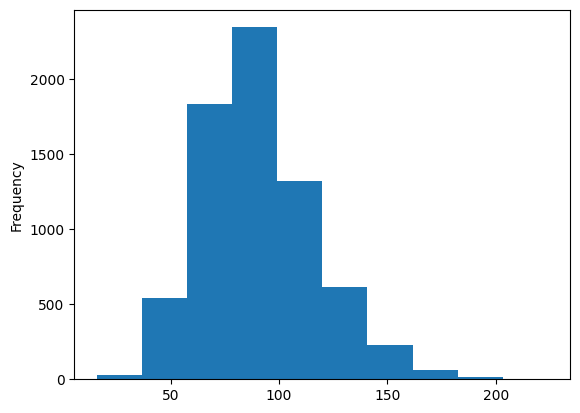

In [7]:
sampledf["question"].str.len().plot(kind='hist',bins=10)

Text(0.5, 0, 'length->')

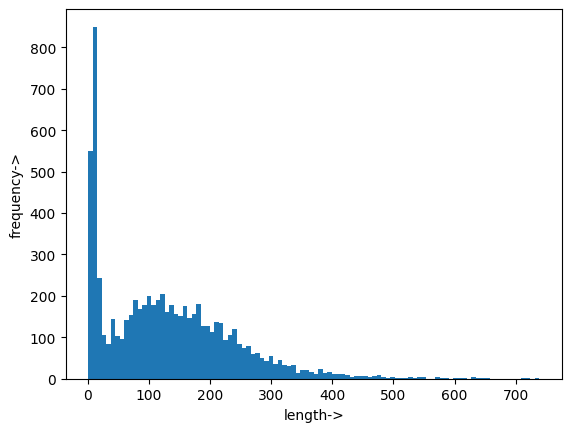

In [8]:
sampledf["answer"].str.len().plot(kind='hist',bins=100)
plt.ylabel("frequency->")
plt.xlabel("length->")

Text(0.5, 0, 'length->')

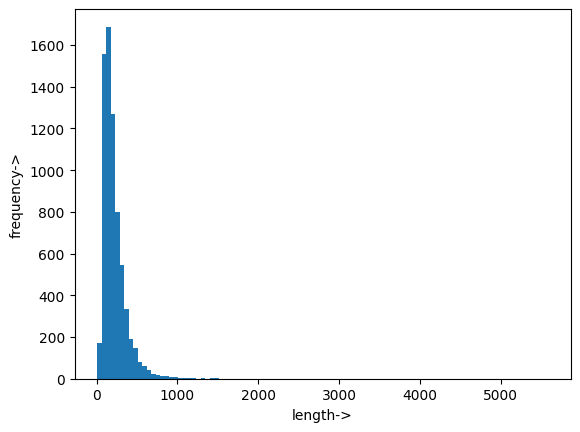

In [55]:
sampledf["context"].str.len().plot(kind='hist',bins=100)
plt.ylabel("frequency->")
plt.xlabel("length->")

Text(0.5, 0, 'length->')

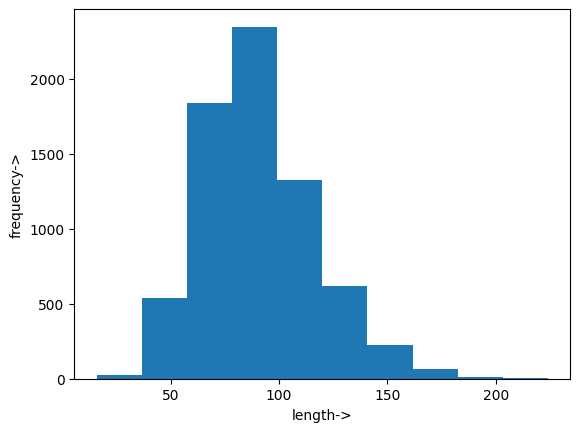

In [54]:
sampledf["question"].str.len().plot(kind='hist',bins=10)
plt.ylabel("frequency->")
plt.xlabel("length->")

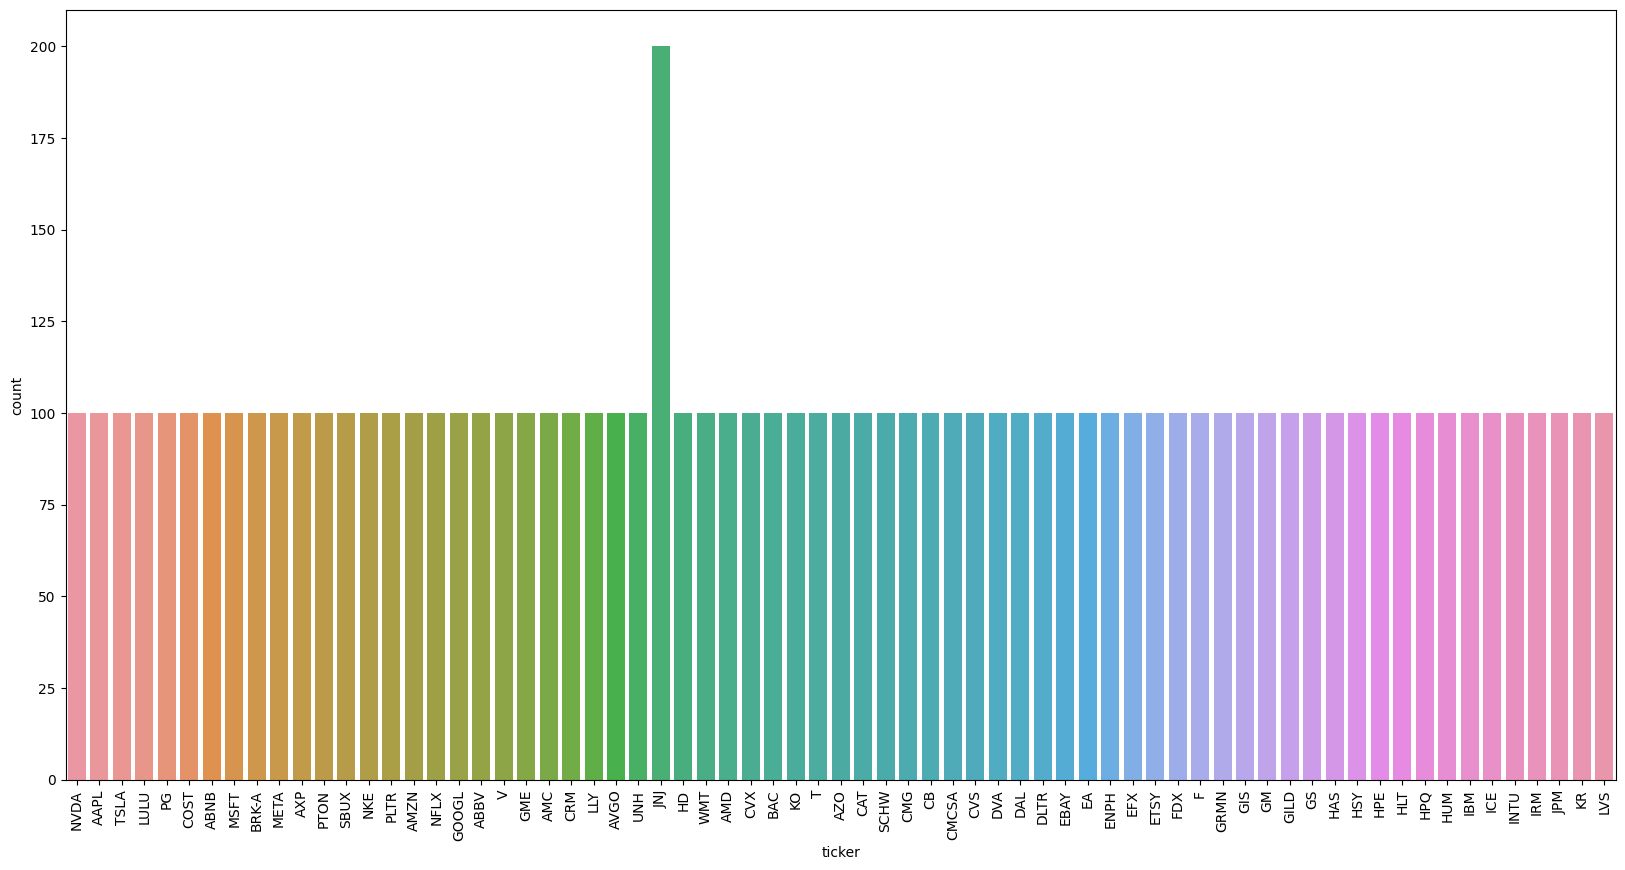

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(data=sampledf,x='ticker')
plt.xticks(rotation=90)
plt.show()

In [11]:

def remove_punctuation(text):
  try:
    text=text.translate(str.maketrans('','',string.punctuation)).lower()
    txt=nlp(text)
    res=[]
    for ent in txt:
      if ent.text not in list(all_stop_word):
          res.append(ent.lemma_)
    return " ".join(res)
  except Exception as ex:
    print(f"text:{ex} {text}")
    return ''

In [12]:
sampledf["clean_context"]=sampledf["context"].apply(lambda x:remove_punctuation(x))
sampledf["clean_answer"]=sampledf["answer"].apply(lambda x:remove_punctuation(x))
sampledf["clean_queston"]=sampledf["question"].apply(lambda x:remove_punctuation(x))

text:'float' object has no attribute 'translate' nan
text:'float' object has no attribute 'translate' nan
text:'float' object has no attribute 'translate' nan
text:'float' object has no attribute 'translate' nan
text:'float' object has no attribute 'translate' nan


In [13]:
def check_common_words(answer,context):
  try:
    return (len(set(answer.split(' ')).intersection(set(context.split(' '))))/len(answer.split(' ')))*100
  except Exception as ex:
    print(f"exeption: {ex}")
    return 100

In [16]:
sampledf["answer_context_commonword"]=sampledf.apply(lambda x: check_common_words(x.clean_answer,x.clean_context),axis=1)

<Axes: ylabel='Frequency'>

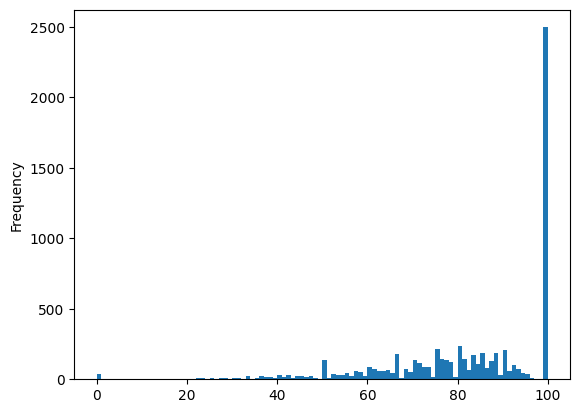

In [17]:
sampledf["answer_context_commonword"].plot(kind='hist',bins=100)

In [18]:
sampledf["answer_context_commonword"].describe()

count    7000.000000
mean       82.136491
std        19.174999
min         0.000000
25%        71.428571
50%        85.714286
75%       100.000000
max       100.000000
Name: answer_context_commonword, dtype: float64

In [19]:
from scipy.stats import ttest_ind

In [20]:
unique_ticker=list(sampledf["ticker"].unique())

In [21]:
for tck in unique_ticker:
  print(ttest_ind(sampledf[sampledf['ticker']==tck]['answer_context_commonword'],sampledf[sampledf['ticker']!=tck]['answer_context_commonword']))

TtestResult(statistic=-1.4100762311759851, pvalue=0.15856161779026787, df=6998.0)
TtestResult(statistic=4.035710230311226, pvalue=5.501749853229047e-05, df=6998.0)
TtestResult(statistic=-1.1899092540091059, pvalue=0.2341224276416025, df=6998.0)
TtestResult(statistic=-7.995358630102253, pvalue=1.5004878013860235e-15, df=6998.0)
TtestResult(statistic=-2.9744861931946245, pvalue=0.002944815322292962, df=6998.0)
TtestResult(statistic=-2.947069321039227, pvalue=0.003218600593799968, df=6998.0)
TtestResult(statistic=-2.1907391994854644, pvalue=0.028503538899863942, df=6998.0)
TtestResult(statistic=-3.6201554636290636, pvalue=0.00029650670761526595, df=6998.0)
TtestResult(statistic=-1.5796912191834194, pvalue=0.11422279292793505, df=6998.0)
TtestResult(statistic=-2.0789291570467943, pvalue=0.03766020023149118, df=6998.0)
TtestResult(statistic=-5.5423258954319286, pvalue=3.0935045070541225e-08, df=6998.0)
TtestResult(statistic=-4.861166126098345, pvalue=1.1923997693912798e-06, df=6998.0)
Ttest

In [22]:
def wordandidx(alltexts):
  wordidx={}
  idxword={}
  idx=1
  for text in alltexts:
    words=text.split(" ")
    for word in words:
      if word not in wordidx:
        wordidx[word]=idx
        idx=idx+1
  idxword={v:i for i,v in wordidx.items()}
  return wordidx,idxword

In [23]:
word2idx,idx2word=wordandidx(list(sampledf["clean_context"]))

In [24]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, ReLU, Bidirectional,BatchNormalization, LayerNormalization, Concatenate, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import categorical_crossentropy 

2024-11-02 23:06:11.870828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 23:06:11.870890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 23:06:11.872677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 23:06:11.885348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 23:06:15.370662: W tensorflow/compiler/tf2

In [76]:
tokenizer_cont = Tokenizer(num_words=len(word2idx), oov_token='<OOV>')
tokenizer_cont.fit_on_texts(sampledf['clean_context'])
text_to_index_cont=tokenizer_cont.texts_to_sequences(list(sampledf["clean_context"]))

In [77]:
tokenizer_ans = Tokenizer(num_words=len(word2idx), oov_token='<OOV>')
tokenizer_ans.fit_on_texts(sampledf['clean_answer'])
text_to_index_ans=tokenizer_ans.texts_to_sequences(list(sampledf["clean_answer"]))

In [78]:
tokenizer_ques = Tokenizer(num_words=len(word2idx), oov_token='<OOV>')
tokenizer_ques.fit_on_texts(sampledf['clean_queston'])
text_to_index_ques=tokenizer_ques.texts_to_sequences(list(sampledf["clean_queston"]))

In [79]:
padded_text_seq_cont=pad_sequences(text_to_index_cont, maxlen=500, padding='post',truncating='post')
padded_text_seq_ans=pad_sequences(text_to_index_ans, maxlen=200, padding='post',truncating='post')
padded_text_seq_ques=pad_sequences(text_to_index_ques, maxlen=100, padding='post',truncating='post')

In [80]:
print(padded_text_seq_ans.shape)
print(padded_text_seq_cont.shape)
print(padded_text_seq_ques.shape)

(7000, 200)
(7000, 500)
(7000, 100)


In [81]:
oh=OneHotEncoder(sparse_output=False)

In [82]:
Y=oh.fit_transform(sampledf["ticker"].iloc[:].values.reshape(-1,1))

In [83]:
print(Y.shape)

(7000, 69)


In [84]:
X_train,X_test, Y_train, Y_test=train_test_split(np.concatenate([padded_text_seq_cont,padded_text_seq_ans,padded_text_seq_ques],axis=1),Y, test_size=0.1)

In [85]:
X_train.shape

(6300, 800)

In [93]:
input1 =Input(shape=(None,), name="Input1")
input2 =Input(shape=(None,), name="Input2")
input3 =Input(shape=(None,), name="Input3")
emdeddinglayer1=Embedding(len(word2idx),64)(input1)
emdeddinglayer2=Embedding(len(word2idx),64)(input2)
emdeddinglayer3=Embedding(len(word2idx),64)(input3)
lstm1=LSTM(units=64,return_sequences=False)(emdeddinglayer1)

lstm2=LSTM(units=64,return_sequences=False)(emdeddinglayer2)

lstm3=LSTM(units=64,return_sequences=False)(emdeddinglayer3)
flat1=Flatten()(lstm1)
flat2=Flatten()(lstm2)
flat3=Flatten()(lstm3)
# lstm2=Bidirectional(LSTM(units=64))(lstm)
concat = Concatenate()([flat1,flat2, flat3])
# flat=Flatten()(concat)
# norm=LayerNormalization()(concat)
dense1=Dense(128, activation='relu')(concat)
norm2=BatchNormalization()(dense1)
dense2=Dense(100, activation='relu')(norm2)
dense3=Dense(len(target_class),activation='softmax')(dense2)

In [94]:
X_test.shape

(700, 800)

In [95]:
model=Model(inputs=[input1, input2, input3],outputs=dense3)

In [96]:
model.compile(optimizer=AdamW(learning_rate=0.001),loss='categorical_crossentropy',metrics=['acc'])

In [97]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 Input3 (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, None, 64)             689216    ['Input1[0][0]']              
                                                                                            

In [98]:
def batch_geneartor(x1,x2,x3,y,batch_size=16):
    indices=np.arange(len(x1))
    batch=[]
    while True:
        np.random.shuffle(indices)
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield x1[batch],x2[batch],x3[batch],y[batch]
                batch=[]
            else:
                yield x1[batch],x2[batch],x3[batch],y[batch]
                

In [99]:
next(batch_geneartor(X_train[:,0:50],X_train[:,50:100],X_train[:,100:150], Y_train)
)

(array([[ 138,   22,   29,   27,    7,   25,   15,   14,    2, 2738,   40,
         5181,    7,   25,   15,   14,    6,    9,   33,   42,  557,   29,
           55,   46,  239,  655,   92, 1022,  709,   22,  150,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]], dtype=int32),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=int32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0

In [100]:
val_acc_metric=tf.keras.metrics.CategoricalAccuracy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()



In [101]:
def perform_validation(inp1,inp2,inp3,y):
  losses = []
#   for x_val, y_val in test:
  val_logits = model([inp1,inp2,inp3])
  val_loss = categorical_crossentropy(y_true=y, y_pred=val_logits)
  losses.append(val_loss)
  val_acc_metric(y, val_logits)
  return np.mean(losses)

In [102]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [103]:
device

'/gpu:0'

In [104]:
# @tf.function
train_loss_=[]
train_acc_=[]
valid_loss_=[]
valid_acc_=[]
def train_loop(X_train,X_test,Y_train,Y_test, epoch=100):
    with mlflow.start_run():
        for i in range(0,epoch):
            loss_mean=[]
            for j in range(0,len(X_train)//32):
                inp1,inp2,inp3,y=next(batch_geneartor(X_train[:,0:500],X_train[:,500:700],X_train[:,700:800], Y_train))
                with tf.device(device_name=device):
                    with tf.GradientTape() as tape:
                        output=model([inp1,inp2,inp3])
                        loss=categorical_crossentropy(y,output)
                        loss_mean.append(loss)
#                         mlflow.log_param("batch_number",j)
                        mlflow.log_metric("batch_loss",loss)
                    grads = tape.gradient(loss,model.trainable_variables)
                    optimizer.apply_gradients(zip(grads,model.trainable_variables))
                    train_acc_metric.update_state(y,output)
            print(f"Train loss {i} {np.mean(loss_mean)} accuracy {train_acc_metric.result()}")
#             mlflow.log_param("train_number",i)
           
            
            val_loss=perform_validation(X_test[:,0:50],X_test[:,50:100],X_test[:,100:150], Y_test)
            print(f"Valid_loss {val_loss} validation_accuracy {val_acc_metric.result()}")
            valid_acc_.append(val_acc_metric.result())
            train_acc_.append(train_acc_metric.result())
            train_loss_.append(loss)
            valid_loss_.append(val_loss)
#             mlflow.log_param("valid_loss",i)
            mlflow.log_metric("train_loss",np.mean(loss_mean))
            mlflow.log_metric("valid_loss",val_loss)
            mlflow.log_metric("train_accuracy",train_acc_metric.result())
            mlflow.log_metric("valid_accuracy",val_acc_metric.result())
            

In [105]:
 train_loop(X_train,X_test,Y_train,Y_test)

Train loss 0 4.2433037757873535 accuracy 0.010204081423580647
Valid_loss 4.241455078125 validation_accuracy 0.02428571507334709
Train loss 1 4.244565010070801 accuracy 0.0076530613005161285
Valid_loss 4.238893508911133 validation_accuracy 0.019999999552965164
Train loss 2 4.249319076538086 accuracy 0.011904762126505375
Valid_loss 4.2398200035095215 validation_accuracy 0.02142857201397419


KeyboardInterrupt: 

In [ ]:
# history=model.fit([X_train[:,0:50],X_train[:,50:100],X_train[:,100:150]],Y_train,epochs=100, batch_size=8, validation_data=[[X_test[:,0:50],X_test[:,50:100],X_test[:,100:150]],Y_test])

In [107]:
tokenizer_cont = Tokenizer(num_words=len(word2idx), oov_token='<OOV>')
tokenizer_cont.fit_on_texts(sampledf['clean_context'])
text_to_index_cont=tokenizer_cont.texts_to_sequences(list(sampledf["clean_context"]))

In [162]:
added_text_seq_cont=pad_sequences(text_to_index_cont, maxlen=100, padding='post',truncating='post')

In [163]:
oh=OneHotEncoder(sparse_output=False)

In [164]:
Y=oh.fit_transform(sampledf["ticker"].iloc[:].values.reshape(-1,1))

In [165]:
X_train,X_test, Y_train, Y_test=train_test_split(padded_text_seq_cont,Y, test_size=0.1)

In [173]:
input1 =Input(shape=(None,), name="Input1")

emdeddinglayer1=Embedding(len(word2idx),64)(input1)

lstm1=LSTM(units=32,return_sequences=False)(emdeddinglayer1)



# lstm2=Bidirectional(LSTM(units=64))(lstm)

# flat=Flatten()(concat)
# norm=LayerNormalization()(concat)
dense1=Dense(128, activation='relu')(lstm1)
# norm2=BatchNormalization()(dense1)
# dense2=Dense(100, activation='relu')(norm2)
dense3=Dense(len(target_class),activation='softmax')(dense1)

In [174]:
model=Model(inputs=input1,outputs=dense3)

In [175]:
def batch_geneartor(x1,y,batch_size=16):
    indices=np.arange(len(x1))
    batch=[]
    while True:
        np.random.shuffle(indices)
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield x1[batch],y[batch]
                batch=[]
            else:
                yield x1[batch],y[batch]
                batch=[]

In [180]:
val_acc_metric=tf.keras.metrics.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)

In [181]:
def perform_validation(inp1,y):
  losses = []
#   for x_val, y_val in test:
  val_logits = model(inp1)
  val_loss = categorical_crossentropy(y_true=y, y_pred=val_logits)
  losses.append(val_loss)
  val_acc_metric(y, val_logits)
  return np.mean(losses)

In [182]:
# @tf.function
train_loss_=[]
train_acc_=[]
valid_loss_=[]
valid_acc_=[]
def train_loop(X_train,X_test,Y_train,Y_test, epoch=100):
    with mlflow.start_run():
        for i in range(0,epoch):
            loss_mean=[]
            for j in range(0,len(X_train)//16):
                inp1,y=next(batch_geneartor(X_train, Y_train))
                with tf.device(device_name=device):
                    with tf.GradientTape() as tape:
                        output=model(inp1)
                        loss=categorical_crossentropy(y,output)
                        loss_mean.append(loss)
#                         mlflow.log_param("batch_number",j)
                        mlflow.log_metric("batch_loss",loss)
                    grads = tape.gradient(loss,model.trainable_variables)
                    optimizer.apply_gradients(zip(grads,model.trainable_variables))
                    train_acc_metric.update_state(y,output)
            print(f"Train loss {i} {np.mean(loss_mean)} accuracy {train_acc_metric.result()}")
#             mlflow.log_param("train_number",i)
           
            
            val_loss=perform_validation(X_test, Y_test)
            print(f"Valid_loss {val_loss} validation_accuracy {val_acc_metric.result()}")
            valid_acc_.append(val_acc_metric.result())
            train_acc_.append(train_acc_metric.result())
            train_loss_.append(loss)
            valid_loss_.append(val_loss)
#             mlflow.log_param("valid_loss",i)
            mlflow.log_metric("train_loss",np.mean(loss_mean))
            mlflow.log_metric("valid_loss",val_loss)
            mlflow.log_metric("train_accuracy",train_acc_metric.result())
            mlflow.log_metric("valid_accuracy",val_acc_metric.result())
            

In [ ]:
 train_loop(X_train,X_test,Y_train,Y_test)

Train loss 0 4.321005344390869 accuracy 4.321006774902344
Valid_loss 4.282421112060547 validation_accuracy 4.282420635223389
Train loss 1 4.280115604400635 accuracy 4.300561428070068
Valid_loss 4.258927345275879 validation_accuracy 4.270673751831055
Train loss 2 4.269747734069824 accuracy 4.290286540985107
Valid_loss 4.2530694007873535 validation_accuracy 4.264805793762207
Train loss 3 4.236441612243652 accuracy 4.276828289031982
Valid_loss 4.257030010223389 validation_accuracy 4.262861728668213


In [ ]:
plt.plot(train_loss_)
plt.plot(valid_loss_)

In [ ]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])